In [1]:
import os
import ml_collections
import numpy as np
import cv2
import matlab.engine # the matlab engine for python
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

from wavebench.generate_data.time_varying.generate_data_rtc import generate_rtc
from wavebench import wavebench_dataset_path
from wavebench.generate_data.time_varying.gaussian_random_field import generate_gaussian_random_field
from wavebench.utils import absolute_file_paths, seed_everything


In [16]:
thick_lines_data_path = os.path.join(
    wavebench_dataset_path, "time_varying/thick_lines")

config = ml_collections
config.save_data = False

config.domain_sidelen = 512
config.domain_dx = 2

# config.medium_type = 'gaussian_lens' # 'gaussian_random_field'
config.medium_type = 'gaussian_random_field'

config.medium_source_loc = (199, 219)
config.medium_density = 2650
config.pml_size = 10

#  define the properties of the propagation medium
min_wavespeed = 1400
max_wavespeed = 4000
point_mass_strength = -31000

if config.medium_type == 'gaussian_lens':
    z = np.ones((config.domain_sidelen,config.domain_sidelen))
    z[config.medium_source_loc] = point_mass_strength
    medium_sound_speed = cv2.GaussianBlur(
        z,
        ksize=(0, 0),
        sigmaX=200,
        borderType=cv2.BORDER_REPLICATE)
elif config.medium_type == 'gaussian_random_field':
    seed_everything(42)
    medium_sound_speed = generate_gaussian_random_field(
        size = config.domain_sidelen,
        alpha=3.0)
else:
    raise NotImplementedError

medium_sound_speed -= medium_sound_speed.min()
medium_sound_speed /= medium_sound_speed.max()

config.medium_sound_speed = medium_sound_speed*(
max_wavespeed - min_wavespeed) + min_wavespeed

# only a single example is generated
config.source_list = sorted(absolute_file_paths(thick_lines_data_path))[:1]
initial_pressure_dataset, final_pressure_dataset = generate_rtc(config)
jwave_final_pressure = final_pressure_dataset[0]

Save data? False


100%|██████████| 1/1 [00:14<00:00, 14.82s/it]


: 

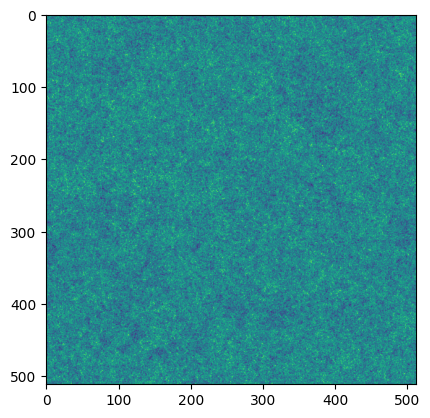

In [15]:
plt.imshow(config.medium_sound_speed)


In [4]:

eng = matlab.engine.start_matlab()

kwave_final_pressure = eng.compute_rtc_final(
  np.double(config.medium_sound_speed),
  np.double(config.medium_density),
  np.double(config.domain_dx),
  initial_pressure_dataset[0])
kwave_final_pressure = np.array(kwave_final_pressure)



ans = 

    ""Compute the final pressure field using MATLAB's k-Wave toolbox.""

Running k-Wave simulation...
  start time: 06-May-2023 20:30:45
  reference sound speed: 4000m/s
  dt: 150us, t_end: 200.1ms, time steps: 1335
  input grid size: 512 by 512 grid points (1.024 by 1.024km)
  maximum supported frequency: 350Hz
  smoothing p0 distribution...
  smoothing sound speed distribution...
  precomputation completed in 0.26644s
  starting time loop...
  estimated simulation time 13.3358s...
  simulation completed in 10.5319s
  total computation time 10.8036s


In [11]:
mse = np.mean( (kwave_final_pressure - jwave_final_pressure)**2 )
np.testing.assert_array_less(mse, 1e-4)


Text(0.5, 1.0, 'diff')

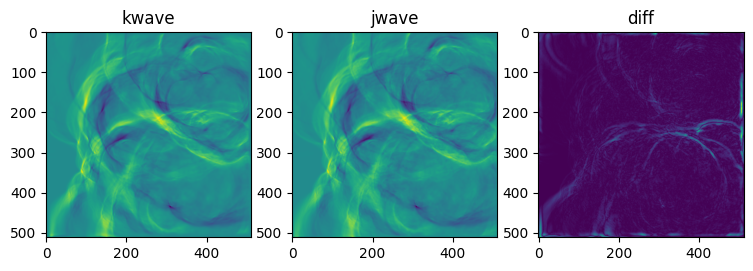

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(kwave_final_pressure)
axes[0].set_title('kwave')
axes[1].imshow(jwave_final_pressure)
axes[1].set_title('jwave')
axes[2].imshow(np.abs(jwave_final_pressure - kwave_final_pressure))
axes[2].set_title('diff')

